# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive




##Importing Kaggle Dataset

In [ ]:
!unzip /content/drive/MyDrive/fresh_rotten_classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.09 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.18 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.24 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.37 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.02.51 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.02 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.12 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.21 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07 at 3.03.31 PM.png  
  inflating: dataset/train/rottenapples/rotated_by_60_Screen Shot 2018-06-07

##Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report
import pathlib

##Loading Dataset

In [ ]:
dataset_path = "/content/dataset/train"
dataset_dir = pathlib.Path(dataset_path)
val_path = "/content/dataset/test"
val_dir = pathlib.Path(val_path)

In [ ]:
# list of sub directory(class)

class_names = []
for root, dirs, files in os.walk(dataset_path):
    if len(root) > len(dataset_path):
        x_class = os.path.relpath(root, dataset_path)
        class_names.append(x_class)

print(class_names)

['rottenbanana', 'rottenapples', 'freshbanana', 'freshapples', 'freshoranges', 'rottenoranges']


In [ ]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.png')))
    print(f"Images in class {class_i}:",image_count)

Images in class rottenbanana: 2224
Images in class rottenapples: 2342
Images in class freshbanana: 1581
Images in class freshapples: 1693
Images in class freshoranges: 1466
Images in class rottenoranges: 1595


In [ ]:
# Parameter setting
train_batch = 128
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
tr_split = 0.1
val_split = 0.7

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=tr_split,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=train_batch
)

Found 10901 files belonging to 6 classes.
Using 9811 files for training.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=val_batch
                                                    )

Found 2698 files belonging to 6 classes.
Using 1888 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


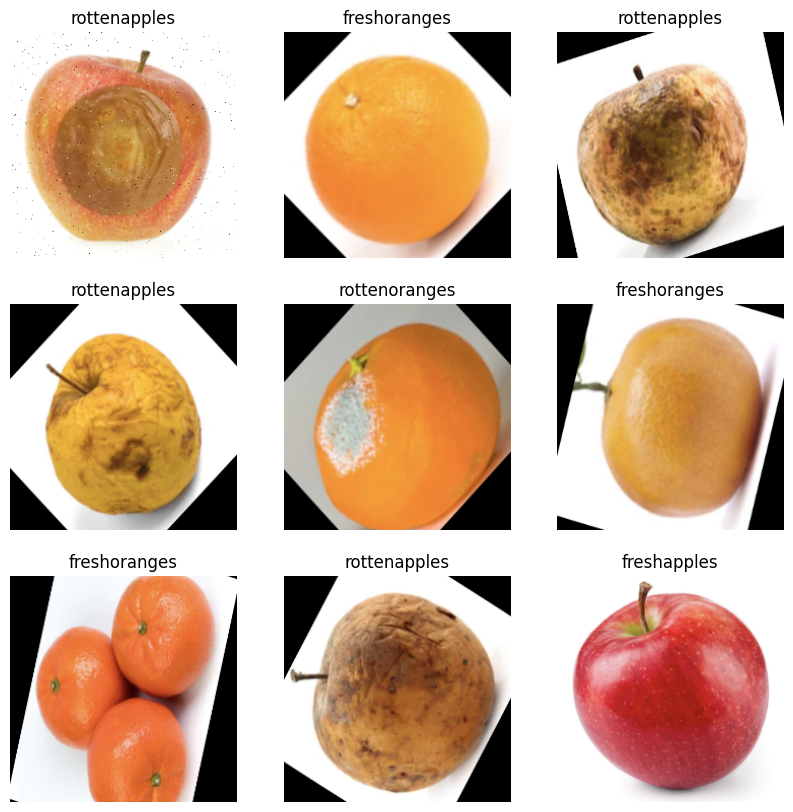

In [ ]:
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

##Data Preprocessing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##**CNN Model Building**

In [ ]:
#Data augmentation layers to increase data variation for training
data_augmentation = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
# Model architecture
cnn_model = Sequential([
    layers.Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [ ]:
# compile model
base_learning_rate = 0.0005
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# display model
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         802,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 812,822 (3.10 MB)

 Trainable params: 812,694 (3.10 MB)

 Non-trainable params: 128 (512.00 B)

##CNN Model Training

In [ ]:
epochs=10
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=0
)

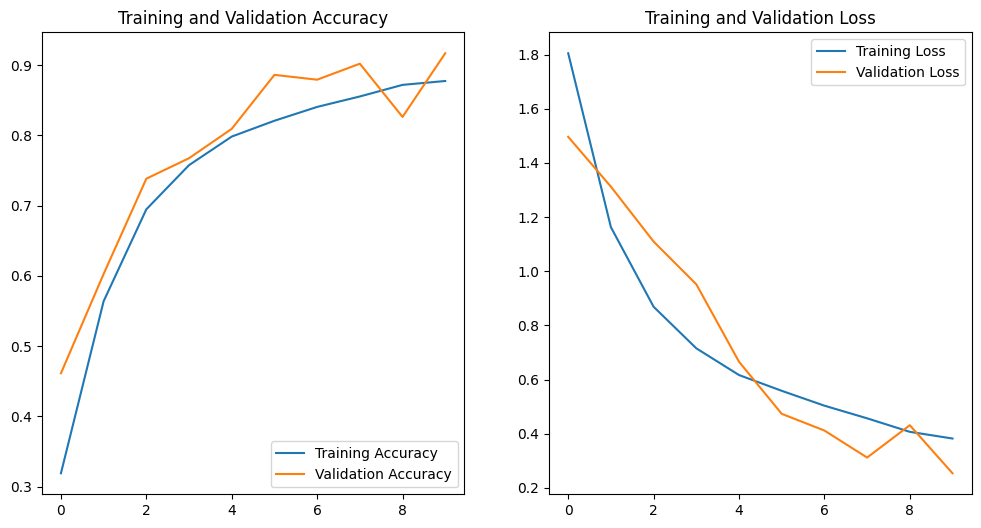

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Model Evaluation

Predictions:
 [4 5 0 3 2 5 0 0 1 2 5 2 1 3 1 4 4 3 2 2 2 4 3 2 1 3 0 0 2 3 3 3 2 4 3 1 0
 0 0 3 1 3 0 4 3 3 1 3 3 1 3 3 1 4 1 2 4 0 4 2 0 4 1 2 0 0 5 3 4 4 4 1 1 4
 5 4 3 3 0 3 1 3 2 3 3 3 3 4 3 3 4 4 1 5 0 0 1 5 3 3 5 4 1 4 4 0 5 0 4 3 0
 3 2 4 1 2 1 4 3 3 4 3 0 4 4 1 4 5]
Labels:
 [4 5 0 3 2 5 0 0 1 2 5 2 1 5 0 4 4 3 2 2 2 4 3 2 1 3 0 3 2 0 3 3 2 4 3 1 3
 0 3 3 1 3 0 4 3 3 1 3 3 1 5 3 1 4 1 2 4 0 4 2 0 4 1 2 0 0 5 3 4 4 4 1 1 4
 5 4 3 3 3 3 1 3 2 3 3 3 3 4 3 3 4 4 1 5 0 0 1 5 3 3 5 4 1 4 4 0 5 0 4 3 3
 3 2 4 1 2 1 4 3 3 4 3 0 4 4 1 4 5]

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        17
           1       0.95      1.00      0.97        19
           2       1.00      1.00      1.00        15
           3       0.91      0.86      0.89        37
           4       1.00      1.00      1.00        28
           5       1.00      0.83      0.91        12

    accuracy                           0.93       128
   macro avg       0

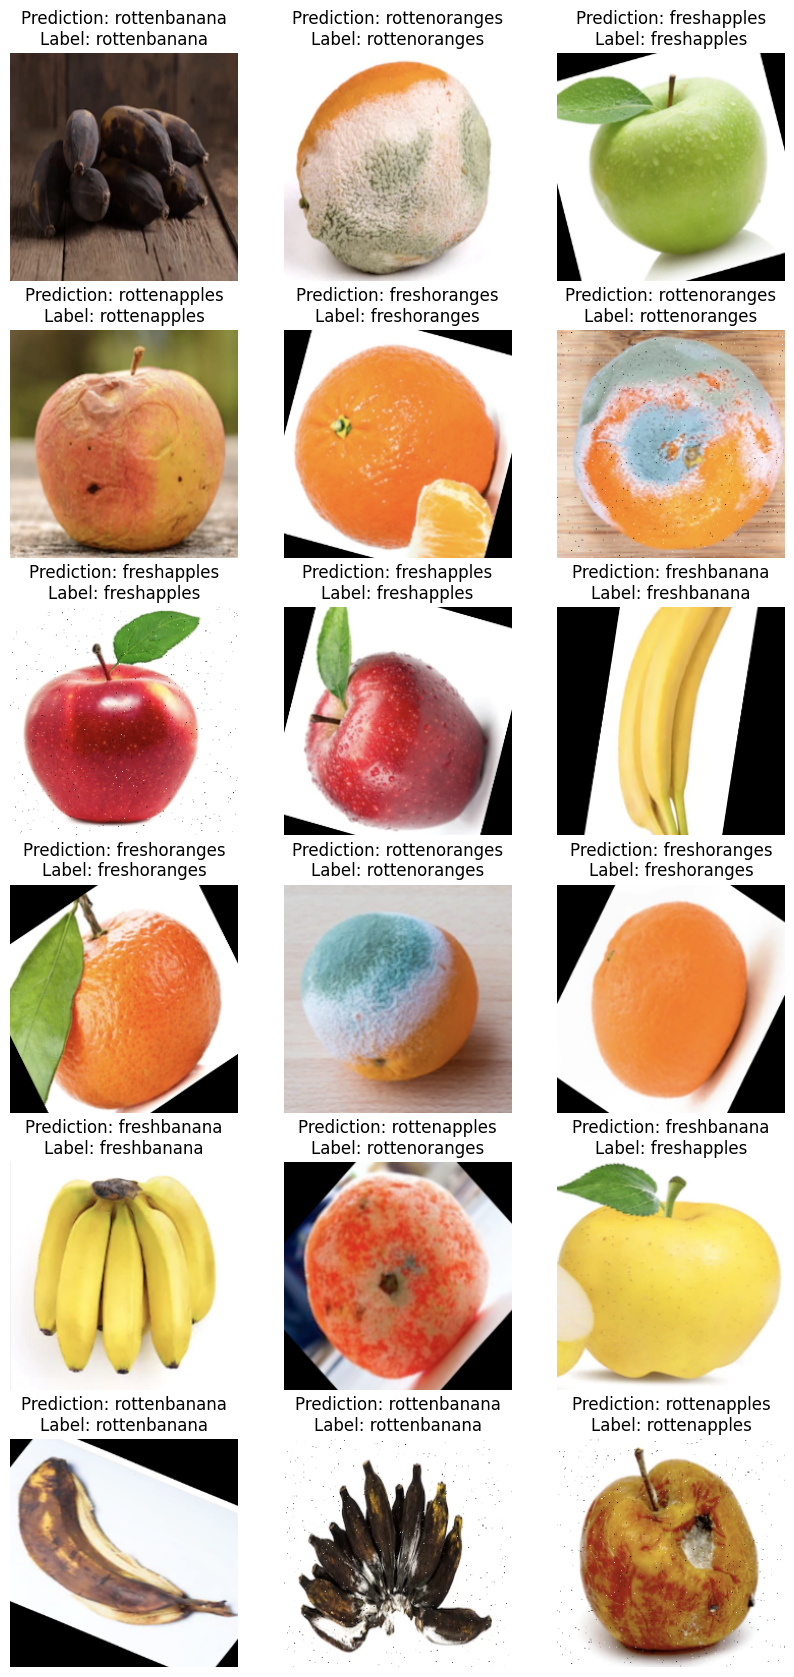

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = cnn_model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

##The CNN Model shows a Testing Accuracy of 92%

In [ ]:
def predict_single_image(img_path, model, img_size=(224, 224)):
    # Load image and resize it with bicubic interpolation
    img = image.load_img(img_path, target_size=img_size, interpolation='bicubic')

    # Convert the image to an array and preprocess it
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Normalize the image
    img_array /= 255.0

    # Make prediction
    predictions = model.predict(img_array)

    # Convert logits to probabilities
    predicted_class = np.argmax(predictions, axis=1)

    # Return the predicted class
    return predicted_class

img_path = ''
predicted_class = predict_single_image(img_path, cnn_model)

print(f"Predicted class: {predicted_class}")